# LPIPS evaluation

In [ ]:
import os
import glob

def read_directory(path):
    return glob.glob(os.path.join(path, '*'))

path = "Image-Super-Resolution-via-Iterative-Refinement/experiments/sr3_dsr_240606_171423/results/"
files = read_directory(path)

# Initialize lists
process_files = []
sr_files = []
hr_files = []

# Sort files into lists
for file in files:
    filename = file.split('/')[-1]
    if 'process' in filename:
        process_files.append(file)
    elif 'sr' in filename and 'process' not in file:
        sr_files.append(file)
    elif 'hr' in filename:
        hr_files.append(file)

print('Process files:', process_files[:3])
print('SR files:', sr_files[:3])
print('HR files:', hr_files[:3])

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure the same index for sr_files and hr_files
indices = random.sample(range(len(sr_files)), 5)
random_sr_files = [sr_files[i] for i in indices]
random_hr_files = [hr_files[i] for i in indices]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot SR files in the first row
for i, file in enumerate(random_sr_files):
    img = mpimg.imread(file)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')

# Plot HR files in the second row
for i, file in enumerate(random_hr_files):
    img = mpimg.imread(file)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')

# Remove white space between images
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("sr3_sample_real.png", bbox_inches='tight')
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

lpips_metric = LearnedPerceptualImagePatchSimilarity(net_type='alex')

transform = transforms.Compose([
    transforms.ToTensor(),
])

def load_image(file):
    image = Image.open(file).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

lpips_values = []
for sr_file, hr_file in zip(sr_files, hr_files):
    sr_image = load_image(sr_file)
    hr_image = load_image(hr_file)
    lpips_value = lpips_metric(sr_image, hr_image)
    lpips_values.append(lpips_value.item())

# Compute and print the average LPIPS value
average_lpips = sum(lpips_values) / len(lpips_values)
print("Average LPIPS value:", average_lpips)

# Evaluation on real world images

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio

from diffusers import UNet2DModel, DDIMScheduler
from srd import SuperResolutionDataset
from diffusers.optimization import get_cosine_schedule_with_warmup, get_constant_schedule

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
import copy
import cv2
import os
import json
import time

from PIL import Image
from dsr import DSRDataset
from pathlib import Path
from accelerate import Accelerator

from samplers import DDIMPipeline 
        
root = Path('./dsr/')

with open(root / 'train_valid_test_split.json', 'r') as f:
    split = json.load(f)

train_dataset = DSRDataset(root, split['train'], resolution=128, real_lr=True)
val_dataset = DSRDataset(root, split['test'], resolution=128, real_lr=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=2,
    shuffle=True,
    prefetch_factor=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=2,
    shuffle=True,
    prefetch_factor=2
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(train_dataset.ALTITUDES)
    
model = UNet2DModel(
    sample_size=128,  # the target image resolution
    in_channels=6,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 256),  # the number of output channels for each UNet block
    norm_num_groups=1,
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    )
).to(device)

state_dict = torch.load('models/dsr_sr.pth' )
model.load_state_dict(state_dict)

T = 2000
diffusion_scheduler = DDIMScheduler(num_train_timesteps=T, beta_schedule='squaredcos_cap_v2')
pipeline = DDIMPipeline(unet=model, scheduler=diffusion_scheduler)

/home/zenteno/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loaded 5175 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height None
Loaded 2532 pairs for scenes ['0175', '0169', '0154', '0030', '0180', '0228', '0214', '0229', '0151', '0055', '0071', '0225', '0153', '0102', '0156', '004

Sampling image


  0%|          | 0/50 [00:00<?, ?it/s]

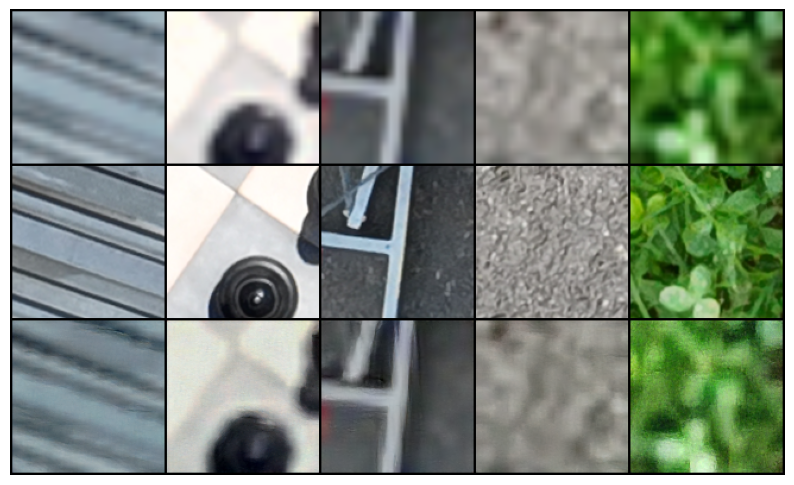

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import torch

print("Sampling image")

X, y, altitudes = next(iter(val_loader))
altitude_conditioning=False
X = X.to(device)
y = y.to(device)
altitudes = altitudes.to(device)

if altitude_conditioning:
    generated_images = pipeline(
        X,
        altitudes=altitudes,
        batch_size=X.shape[0],
        num_inference_steps=50
    )
else:
    generated_images = pipeline(
        X,
        batch_size=X.shape[0],
        num_inference_steps=50
    )

X = (X + 1) / 2
y = (y + 1) / 2

examples = torch.cat((X[:5].cpu(), y[:5].cpu(), generated_images[:5]), dim=0)

grid_images = torchvision.utils.make_grid(examples, nrow=5)
grid_images = grid_images.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 10))
plt.imshow(grid_images)
plt.axis('off')
plt.show()

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# Initialize accumulators for the metrics
psnr_values = []
lpips_values = []
ssim_values = []

pipeline = DDIMPipeline(unet=model, scheduler=diffusion_scheduler)
psnr = PeakSignalNoiseRatio()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
ssim = StructuralSimilarityIndexMeasure()

# Iterate over the validation dataset
progress_bar = tqdm(val_loader, desc="Processing", leave=False)
for X, y, altitudes in progress_bar:
    X = X.to(device)
    y = y.to(device)
    altitudes = altitudes.to(device)

    # Generate images
    generated_images = pipeline(
        X,
        batch_size=X.shape[0],
        num_inference_steps=100
    )

    # Normalize the images
    X = (X + 1) / 2
    y = (y + 1) / 2

    # Compute metrics
    psnr_value = psnr(y.cpu(), generated_images)
    lpips_value = lpips(y.cpu(), generated_images)
    ssim_value = ssim(y.cpu(), generated_images)

    # Accumulate the results
    psnr_values.append(psnr_value.item())
    lpips_values.append(lpips_value.item())
    ssim_values.append(ssim_value.item())

    # Update progress bar with current averages
    avg_psnr = np.mean(psnr_values)
    avg_lpips = np.mean(lpips_values)
    avg_ssim = np.mean(ssim_values)
    progress_bar.set_description(f"LPIPS: {avg_lpips:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

# Compute the final average of the metrics
avg_psnr = np.mean(psnr_values)
avg_lpips = np.mean(lpips_values)
avg_ssim = np.mean(ssim_values)

# Print the final results
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")


Processing:   0%|          | 0/159 [00:00<?, ?it/s]